
# Bayesian Inference for the Mining Disaster Data Set

<img src="imgs/mining.png">

An **exponential** is usually a good choice for a parameter that can have any positive value $z$

$$
Z = {\rm Exp}(\lambda) = P(z|\lambda) = \lambda e^{-\lambda}
$$

The expectation value is:

$$
E[Z | \lambda ] = 1/\lambda
$$

The **Poission** Distribution is usually a good choice for an outcome that can have any positive integer value $k$:

$$
Z = {\rm Poi}(\lambda) = P(k|\lambda) = \frac{\lambda^k e^{-k}}{k!}
$$

The expectation value is:

$$
E[Z | \lambda] = \lambda
$$

cf. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

In [ ]:
import scipy.stats as stats
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, ["r","b"]):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

In [ ]:
import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["r","b"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");


<img src="imgs/mining1.png">

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")

/Users/jbloom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


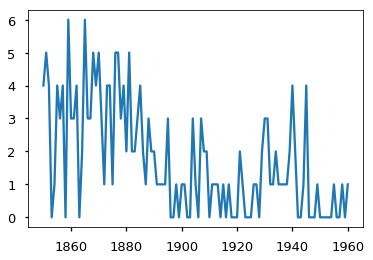

In [2]:
# Disasters/year from 1850-1960
disasters = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5,
                      4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1,
                      3, 2, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0,
                      3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0,
                      1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1,
                      4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
N = len(disasters)
t = np.arange(1850, 1850 + N)
# Generate random test data for comparison
#disasters = np.random.poisson(size=N, lam=2.)
plt.plot(t, disasters)

A model for annual coal mining disaster rates with a changepoint $\tau$:

$$D_t \sim \text{Poisson}\left(\begin{cases}
\mu_1 & t \leq \tau \\
\mu_2 & t > \tau
\end{cases}
\right)$$


In [3]:
with pm.Model() as model:
    # Specify priors for tau, mu_1, mu_2
    tau = pm.DiscreteUniform('tau', lower=t.min(), upper=t.max())
    mu = pm.Exponential('mu', lam=np.array([1., 1.]), shape=2)

    # Poisson likelihood function for observed data
    mu_1_or_2 = pm.Deterministic('mu_1_or_2', pm.math.switch(t < tau, mu[0], mu[1]))
    D = pm.Poisson('D', mu_1_or_2, observed=disasters)

In [5]:
# !pip install pydot

    100% |████████████████████████████████| 133kB 3.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydot ... done
  Stored in directory: /Users/jbloom/Library/Caches/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot


In [4]:
#!brew install graphviz

Let's look at the DAG of the computation we just set up...

In [8]:
from theano.printing import pydotprint
pydotprint(model.logpt)

The output file is available at /Users/jbloom/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.4-64/theano.pydotprint.cpu.png


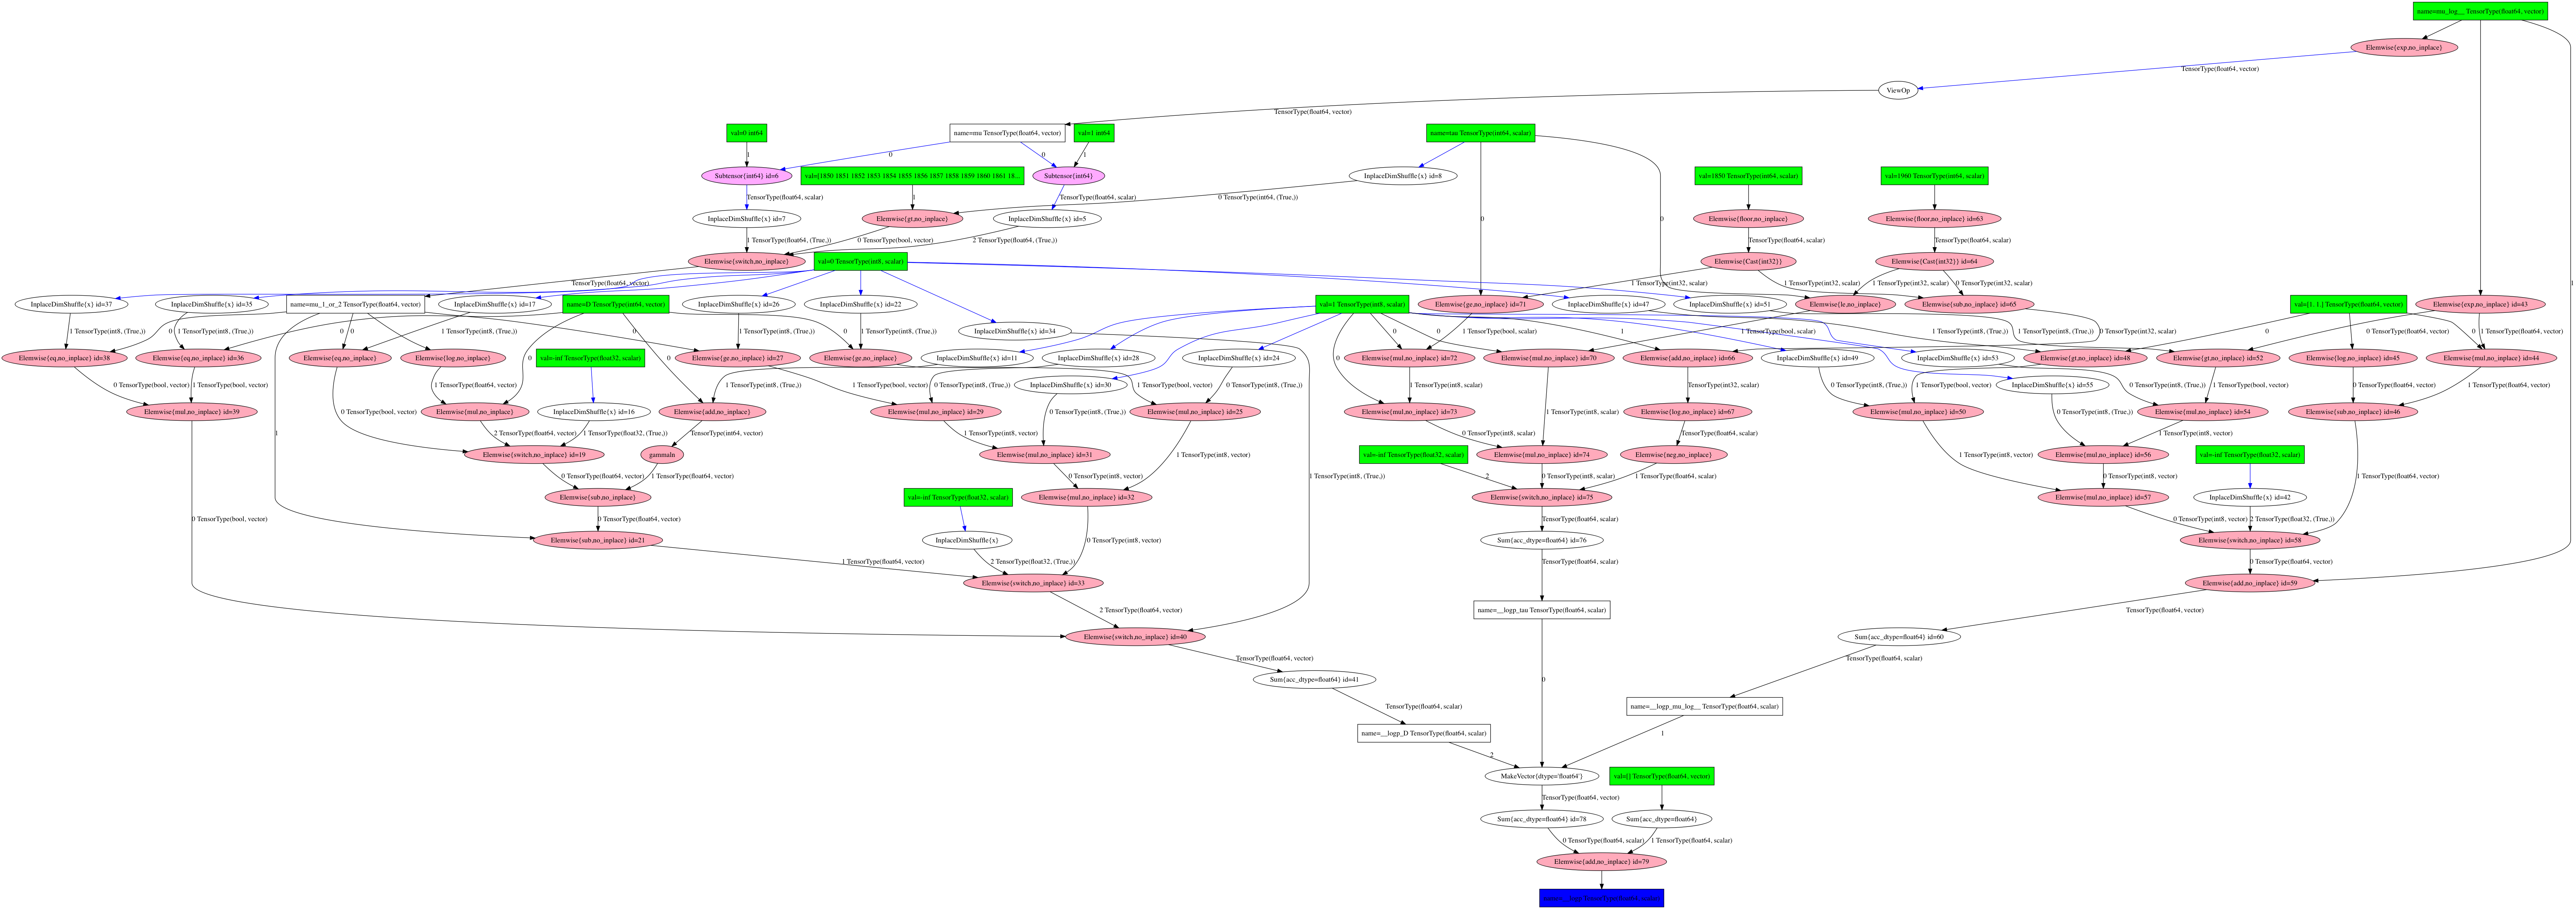

In [9]:
from IPython.display import Image
Image(filename='/Users/jbloom/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.4-64/theano.pydotprint.cpu.png') 

In [12]:
with model:
    step = pm.NUTS()
    trace = pm.sample(20000, step=step, njobs=2)
    
burned_in = trace[5000:]
thinned = burned_in[::10]

/Users/jbloom/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_log__]
>Metropolis: [tau]
100%|█████████▉| 20440/20500 [00:15<00:00, 1360.53it/s]/Users/jbloom/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 20500/20500 [00:15<00:00, 1358.54it/s]
/Users/jbloom/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is smaller than 25% for some parameters.


## Analyzing the posterior
We can get an idea of the behavior of our Markov chain by viewing the trace of one of the variables:

In [ ]:
plt.plot(thinned['tau'])

In [ ]:
# we can obtain summary statistics from the MCMC easily
pm.stats.summary(thinned,  varnames=['mu', "tau"]) #summary statistics

`pymc3` also has its own built-in plotting functionality which helps quickly visualize the distribution of the variables of interest:

In [ ]:
# Variable trace summary plots
pm.plots.traceplot(trace=thinned, varnames=['mu'], figsize=(12, 4));
plt.legend(['mu_1', 'mu_2'])

pm.plots.traceplot(trace=thinned, varnames=['tau']);
plt.legend(['tau'])

In [ ]:
# Detailed posterior distribution plots
pm.plots.plot_posterior(trace=thinned['mu'][:, 0], range=(0.0, 4.5), figsize=(6,6));
pm.plots.plot_posterior(trace=thinned['mu'][:, 1], range=(0.0, 4.5), figsize=(6,6));

Autocorrelation plots give a rough idea of how close to i.i.d the samples from our posterior distribution are:

In [ ]:
# Full chain (no burn-in or thinning)
pm.plots.autocorrplot(trace=trace, varnames=['tau', 'mu']);

In [ ]:
# Chain with 5000 burn-in iterations
pm.plots.autocorrplot(trace=burned_in, varnames=['tau', 'mu']);

In [ ]:
# Chain with 5000 burn-in iterations, thinned by 10x
pm.plots.autocorrplot(trace=thinned, varnames=['tau', 'mu']);

We can also make inferences about the values of other functions/transformations of the parameters:

In [ ]:
# Posterior distribution of change in mean (mu_2 - mu_1)
change = thinned['mu'][:, 1] - thinned['mu'][:, 0]
ci = np.floor(0.975 * len(change))
plt.hist(change);
plt.title('Change in the rate: {:1.3f} (± {:1.3f})'.format(
          np.mean(change), np.abs(np.percentile(change, 2.5) - np.percentile(change, 97.5)) / 2));

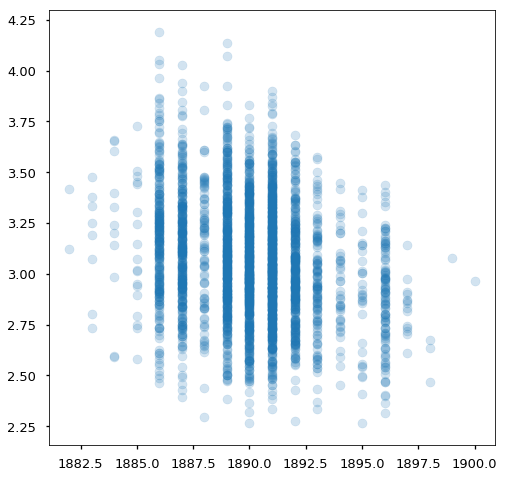

In [50]:
plt.figure(figsize=(8,8))
plt.scatter(thinned[:]["tau"], thinned[:]["mu"][:,0],alpha=0.2)

100%|██████████| 3/3 [00:00<00:00, 75.37it/s]


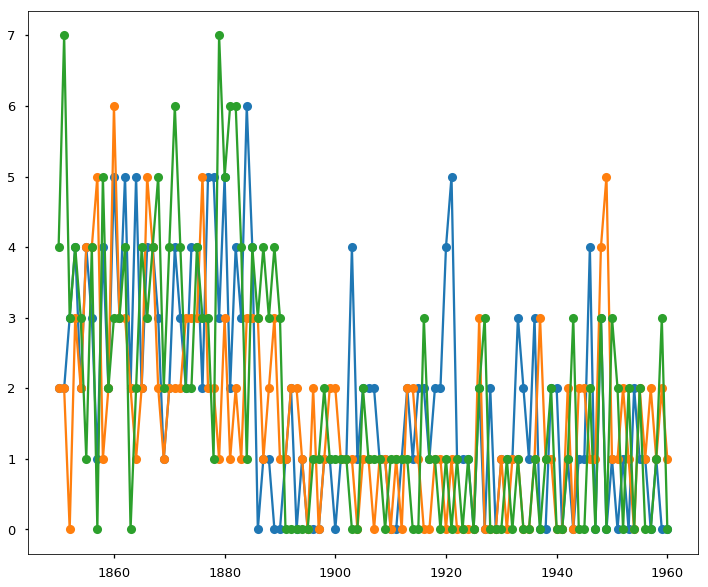

In [26]:
# and we can also plot realizations of the model from the posterior!
plt.figure(figsize=(12, 10))
realizations = pm.sample_ppc(trace, model=model, samples=3)
for D_i in realizations['D']:
    plt.plot(t, D_i, '-o')

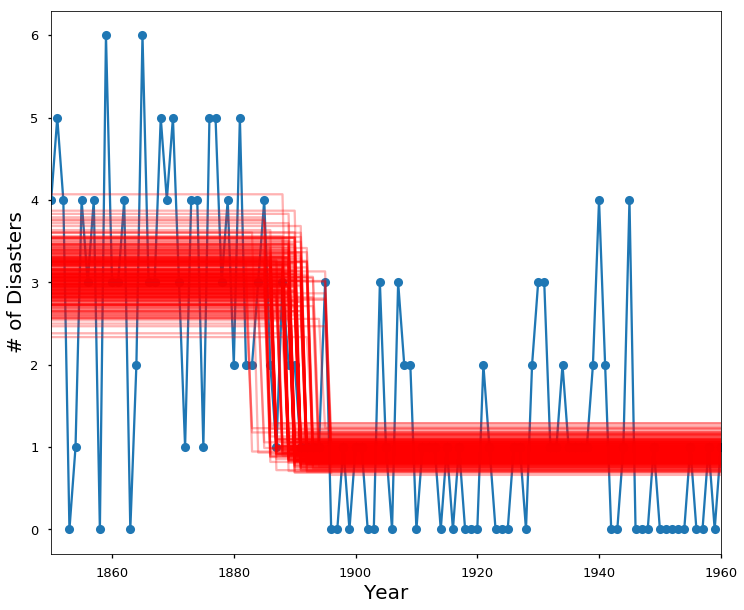

In [34]:
# now we can plot realizations of the model from the posterior!
dates = np.arange(1850,1961)
plt.figure(figsize=(12, 10))

plt.plot(t, disasters,'o-')
plt.xlim([1850,1960])
plt.xlabel('Year',fontsize=20)
plt.ylabel('# of Disasters',fontsize=20)

# plot first 250 MCMC samples
for i in np.arange(250):
    ri = thinned[i]["mu_1_or_2"]
    plt.plot(dates,ri,'-r',alpha=0.3)

In [25]:
pm.stats.quantiles(thinned, qlist=[2.5, 50, 95])[0]["mu"]

{2.5: array([2.53169104, 0.71124996]),
 50: array([3.04013724, 0.93055686]),
 95: array([3.54763852, 1.12724676])}

## Convergence Diagnostics

Determining whether an MCMC has converged can be difficult, especially in high-dimensional parameter spaces 

A number of diagnostics (both formal and informal) exist, and many of these are available in PyMC in `pm.diagnostics` (https://docs.pymc.io/api/diagnostics.html), e.g.:
- Geweke score: compares mean of beginning of chain with mean of end
- Gelman-Rubin: compare variance between chains to variance of single chain

Geweke score = $\frac{\bar{\theta}_e - \bar{\theta}_b}{\sqrt{Var(\theta_e) + Var(\theta_b)}}$

In [ ]:
# Plot Geweke score for tau: should lie between -1 and 1
plt.plot(pm.geweke(trace['tau'])[:, 1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)

In [ ]:
pm.diagnostics.gelman_rubin(thinned['mu'])

- **First check** - start multiple chains from different starting values and see that they converge to the same place
- **More formal methods** - Raftery-Lewis, Geweke, autocorrelation, etc. 
- **Goodness of fit** Posterior Predictive Checks which simulate data from your fitted model and compare to the observed data (checks convergence AND the suitability of the chosen model)

## Other MCMC Code on the Market

- WinBUGS, OpenBUGS - Bayesian inference Using Gibbs Sampling JAGS - Just Another Gibbs Sampler (C++)

- in R -
mcmc, rbugs, BRugs, MCMCpack, adaptMCMC, rjags, etc. See rpy2 (http://rpy.sourceforge.net/rpy2.html)

- in Python -
   - bayesian-inference (http://code.google.com/p/bayesian-inference/) 
   - emcee (http://danfm.ca/emcee/)

## What about Bayesian Approaches to Machine Learning?

- Many of the “Bayesian” ML approaches (e.g., Naive Bayes, Bayes Nets) are usually applied in a Frequentist way
    - “prior” probabilities are estimated with MLE instead of assigning probability distributions (e.g., Dirichlet)

- There are lots of great non-parametric Bayes approaches (many of which are being developed here at UCB!)
   - Gaussian processes (priors over smooth functions)
   - Dirichlet processes (priors over allocation of objects to classes)